In [1]:
import torch
import os
from huggingface_hub import HfApi
from pathlib import Path
from PIL import Image
import numpy as np

from diffusers import (
    ControlNetModel,
    StableDiffusionControlNetPipeline,
    UniPCMultistepScheduler,
)
from diffusers.utils import load_image
from transformers import pipeline

/home/nader/.anaconda/envs/designgenie/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

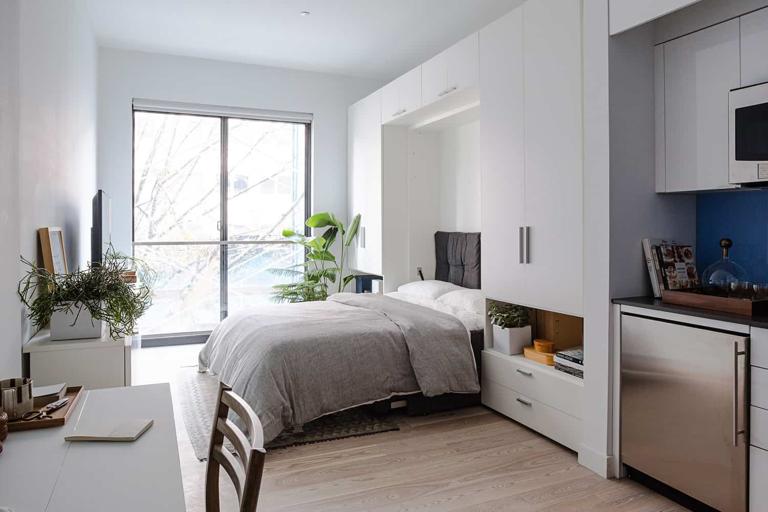

In [3]:
image = load_image(
    "/home/nader/Projects/DesignGenie/assets/images/sample_2.jpg"
).resize((768, 512))
mask_image = load_image(
    "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"
)

image

## Segmentation Module

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from torch import nn

LABELS = requests.get("https://huggingface.co/datasets/huggingface/label-files/raw/main/ade20k-id2label.json").json()

def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

def visualize_segmentation_map(seg):
    # Convert to RGB
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
    palette = np.array(ade_palette())
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color
    # Convert to BGR
    color_seg = color_seg[..., ::-1]

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)


    plt.axis('off')
    plt.imshow(img)

def visaualize_mask(mask, label):
    plt.figure(figsize=(15, 10))
    plt.axis('off')
    plt.title(f"Class ID: {label} - Label: {LABELS[label]}")
    plt.imshow(mask, cmap='gray')

def get_mask_from_segmentation_map(seg_map: torch.Tensor):
    masks = []
    labels = []
    for label, color in enumerate(np.array(ade_palette())):
        mask = np.ones((seg_map.shape[0], seg_map.shape[1]), dtype=np.uint8) # height, width
        indices = (seg_map == label)
        mask[indices] = 0

        if indices.sum() > 0:
            masks.append(mask)
            labels.append(label)

    print(f"Created {len(masks)} masks")
    for idx, label in enumerate(labels):
        print(f"Index: {idx}\tClass ID: {label}\tLabel: {LABELS[str(label)]}")

    return masks, labels

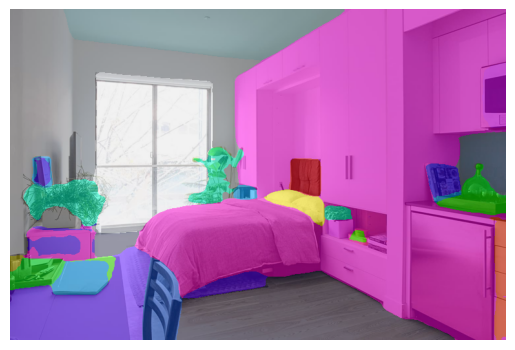

In [6]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from PIL import Image
import requests


processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-ade-semantic")
inputs = processor(images=image, return_tensors="pt")

model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-ade-semantic")
outputs = model(**inputs)
# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to processor for postprocessing
# we refer to the demo notebooks for visualization (see "Resources" section in the MaskFormer docs)
predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

visualize_segmentation_map(predicted_semantic_map)

In [7]:
masks, labels = get_mask_from_segmentation_map(predicted_semantic_map)

Created 24 masks
Index: 0	Class ID: 0	Label: wall
Index: 1	Class ID: 3	Label: floor
Index: 2	Class ID: 5	Label: ceiling
Index: 3	Class ID: 7	Label: bed 
Index: 4	Class ID: 8	Label: windowpane
Index: 5	Class ID: 10	Label: cabinet
Index: 6	Class ID: 15	Label: table
Index: 7	Class ID: 17	Label: plant
Index: 8	Class ID: 19	Label: chair
Index: 9	Class ID: 22	Label: painting
Index: 10	Class ID: 24	Label: shelf
Index: 11	Class ID: 28	Label: rug
Index: 12	Class ID: 33	Label: desk
Index: 13	Class ID: 41	Label: box
Index: 14	Class ID: 44	Label: chest of drawers
Index: 15	Class ID: 57	Label: pillow
Index: 16	Class ID: 66	Label: flower
Index: 17	Class ID: 67	Label: book
Index: 18	Class ID: 98	Label: bottle
Index: 19	Class ID: 124	Label: microwave
Index: 20	Class ID: 125	Label: pot
Index: 21	Class ID: 131	Label: blanket
Index: 22	Class ID: 137	Label: tray
Index: 23	Class ID: 147	Label: glass


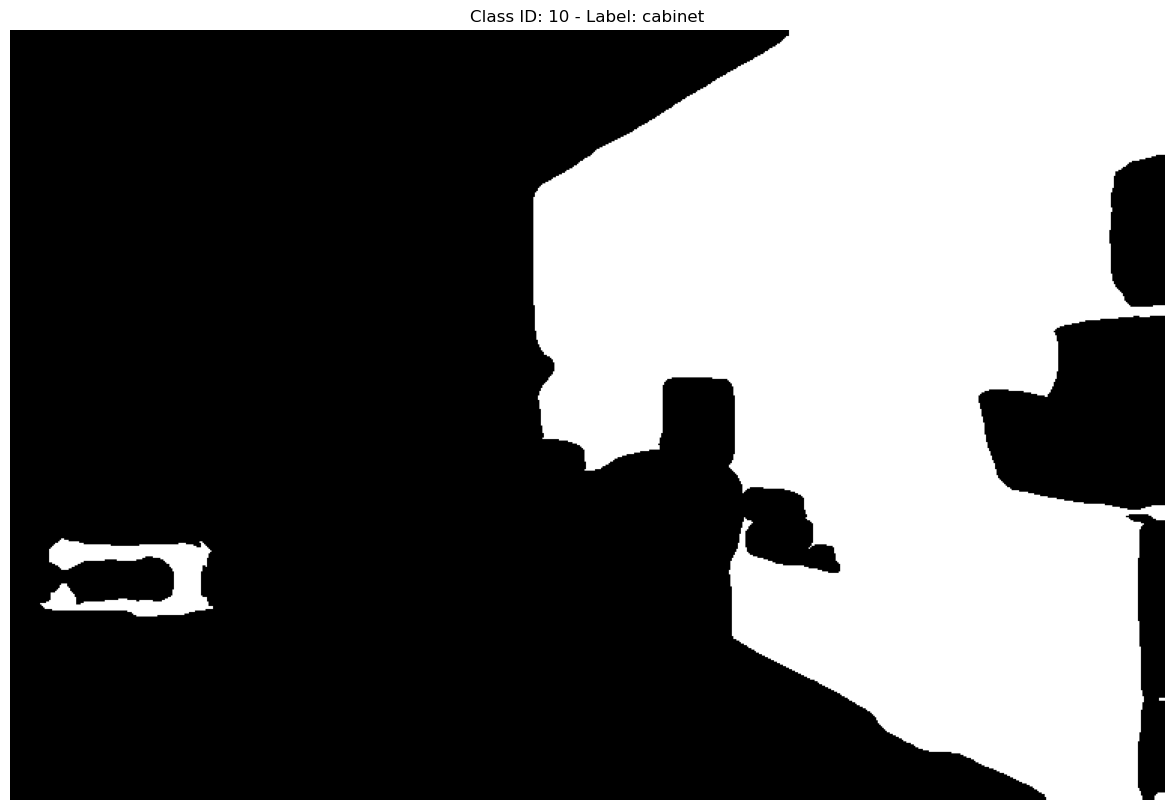

In [8]:
ID = 10
mask = masks[labels.index(ID)]
object_mask = np.logical_not(mask).astype(int)
visaualize_mask(object_mask, label=str(ID))


## ControlNet Modules

### MLSD(Hough) Map

/home/nader/.anaconda/envs/designgenie/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


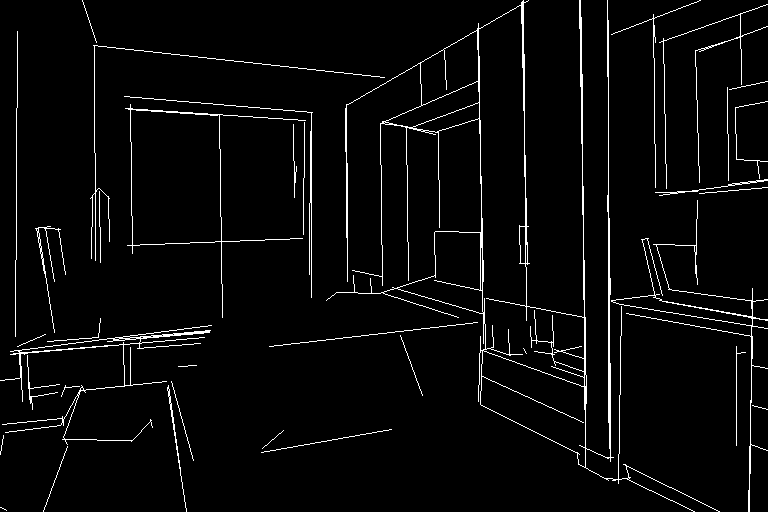

In [10]:
from controlnet_aux import MLSDdetector

processor = MLSDdetector.from_pretrained("lllyasviel/Annotators")
control_image = processor(image)
checkpoint_name = "lllyasviel/control_v11p_sd15_mlsd"

control_image

### Soft Edge

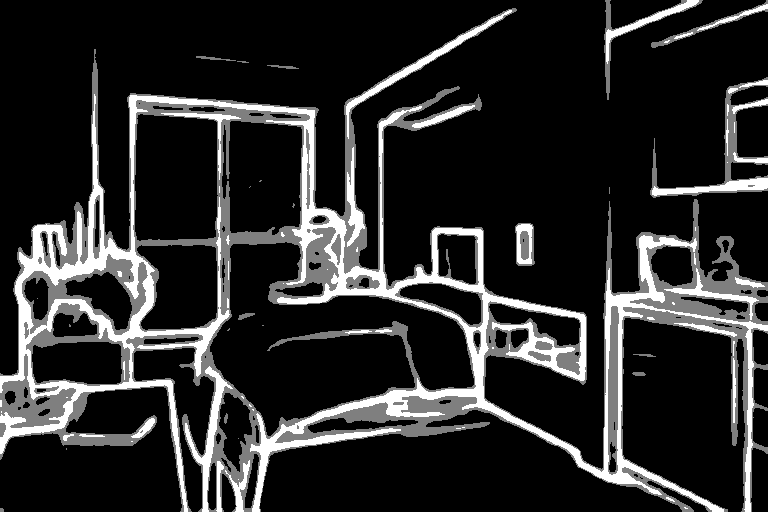

In [74]:
from controlnet_aux import PidiNetDetector, HEDdetector

processor = HEDdetector.from_pretrained('lllyasviel/Annotators')
processor = PidiNetDetector.from_pretrained('lllyasviel/Annotators')
control_image = processor(image, safe=True)

checkpoint_name = "lllyasviel/control_v11p_sd15_softedge"

control_image

### HED Boundary

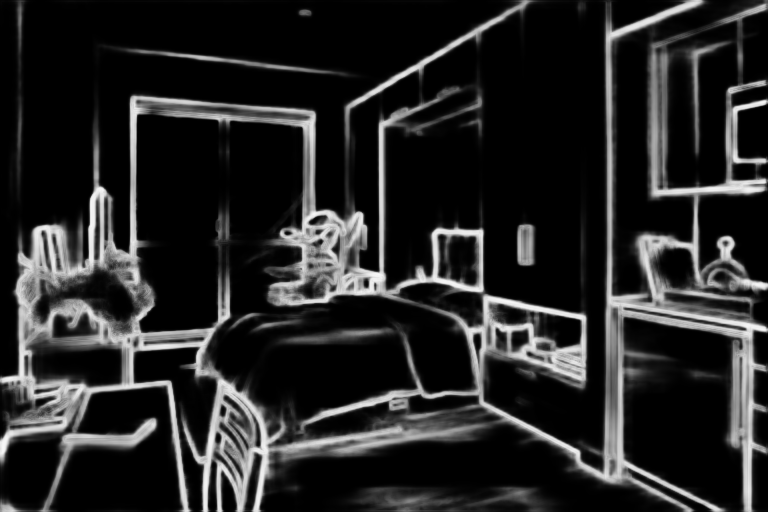

In [112]:
from controlnet_aux import HEDdetector

processor = HEDdetector.from_pretrained('lllyasviel/Annotators')
control_image = processor(image)
checkpoint_name = "lllyasviel/sd-controlnet-hed"

control_image

### Depth Map

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


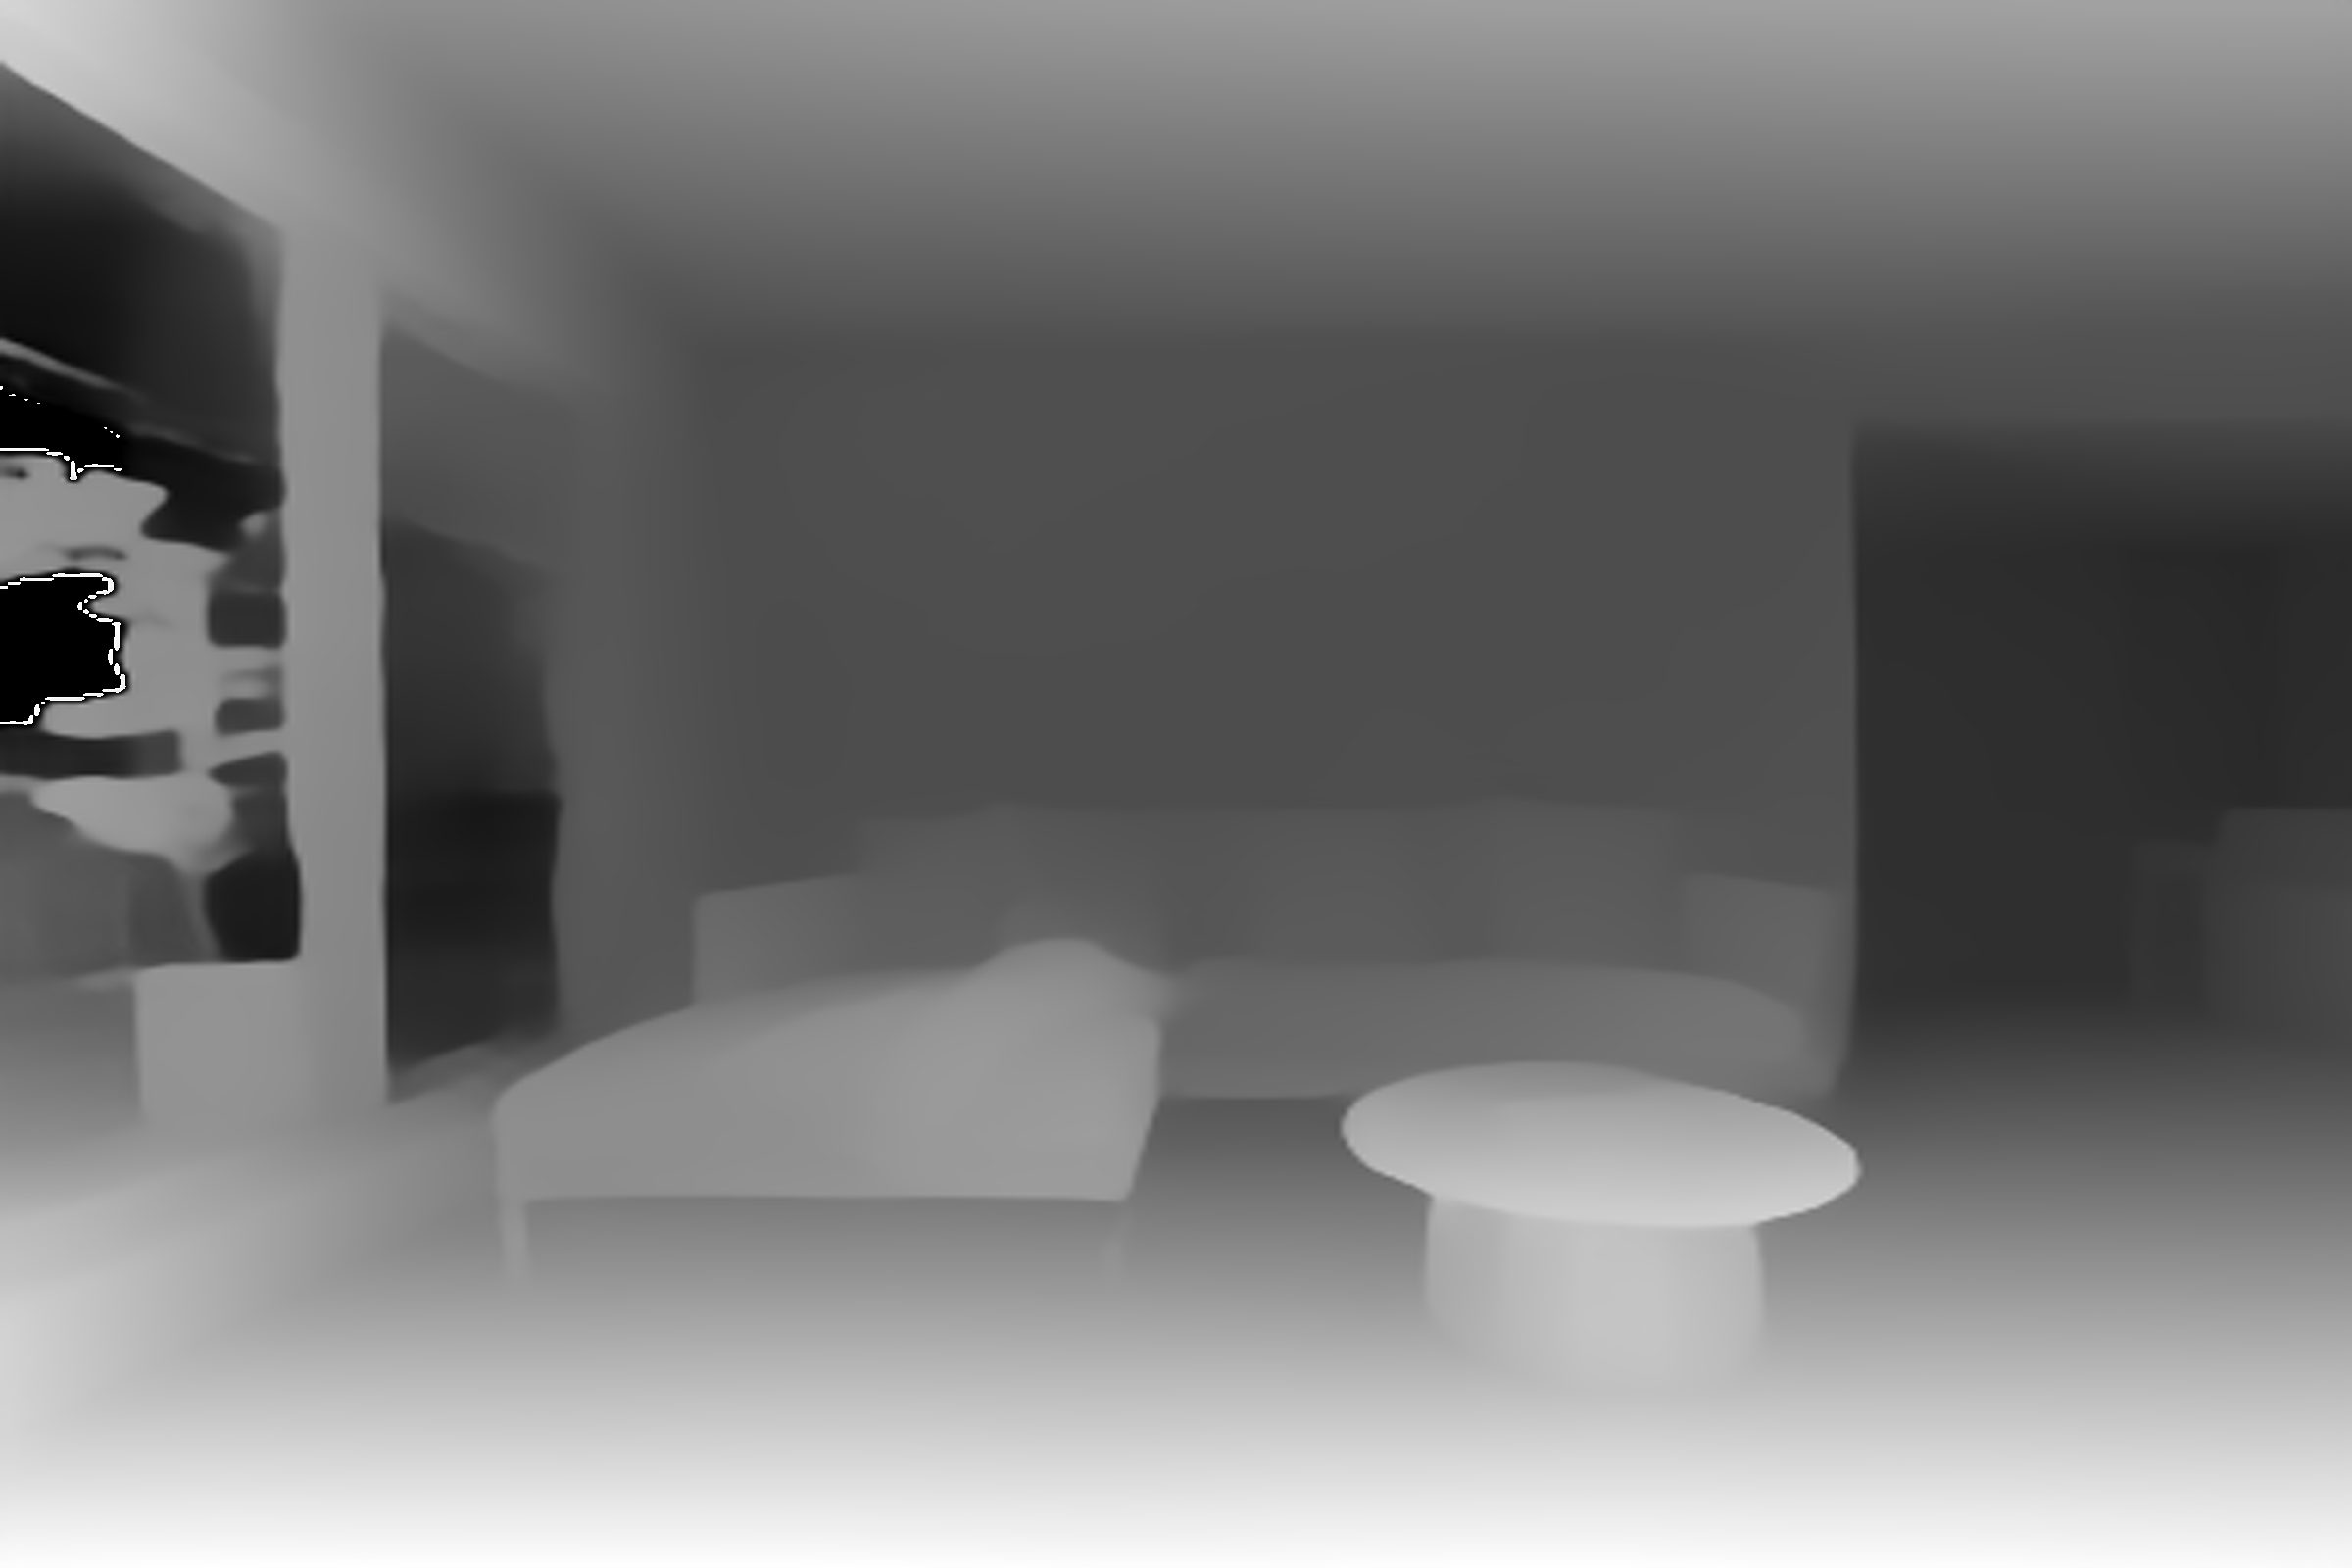

In [3]:
# from controlnet_aux import MidasDetector
# processor = MidasDetector.from_pretrained("lllyasviel/Annotators")
# control_image = processor(image)

depth_estimator = pipeline('depth-estimation')
control_image = depth_estimator(image)['depth']
control_image = np.array(control_image)
control_image = control_image[:, :, None]
control_image = np.concatenate([control_image, control_image, control_image], axis=2)
control_image = Image.fromarray(control_image)

checkpoint_name = "lllyasviel/control_v11p_sd15_depth"

control_image

### Segmentation Map

In [14]:
from controlnet_aux import SamDetector

sam = SamDetector.from_pretrained("/home/nader/DesignGenie/checkpoints/sam_vit_l_0b3195.pth")


HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': '/home/nader/DesignGenie/checkpoints/sam_vit_l_0b3195.pth'. Use `repo_type` argument if needed.

## StableDiffusion ControlNet Pipeline

In [44]:
controlnet = ControlNetModel.from_pretrained(checkpoint_name, torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/home/nader/.anaconda/envs/designgenie/lib/python3.10/site-packages/diffusers/models/attention_processor.py:192: UserWarning: You have specified using flash attention using xFormers but you have PyTorch 2.0 already installed. We will default to PyTorch's native efficient flash attention implementation (`F.scaled_dot_product_attention`) introduced in PyTorch 2.0. In case you are using LoRA or Custom Diffusion, we will fall back to their respective attention processors i.e., we will NOT use the PyTorch 2.0 native efficient flash attention.
  warnings.warn(


In [45]:
import torch
import torchvision.transforms as transforms

mask = torch.Tensor(mask).repeat(3, 1, 1)
object_mask = torch.Tensor(object_mask).repeat(3, 1, 1)
control = transforms.ToTensor()(control_image)
masked_control_image = transforms.ToPILImage()(mask * control)
object_mask = transforms.ToPILImage()(object_mask)

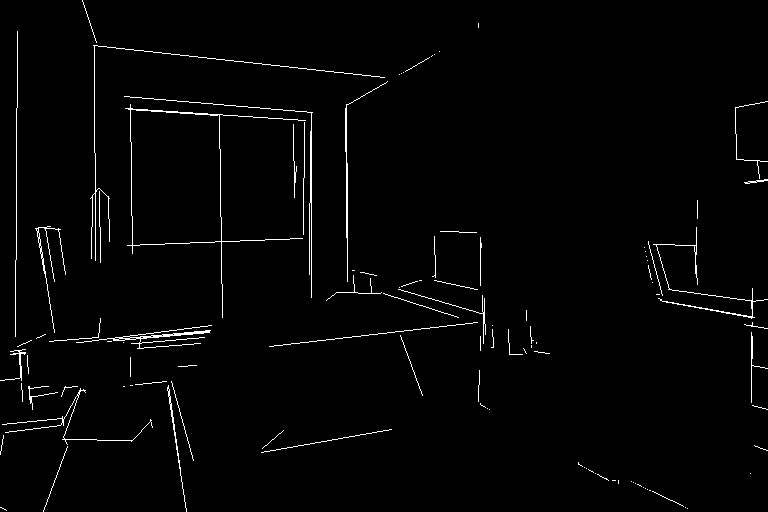

In [46]:
masked_control_image

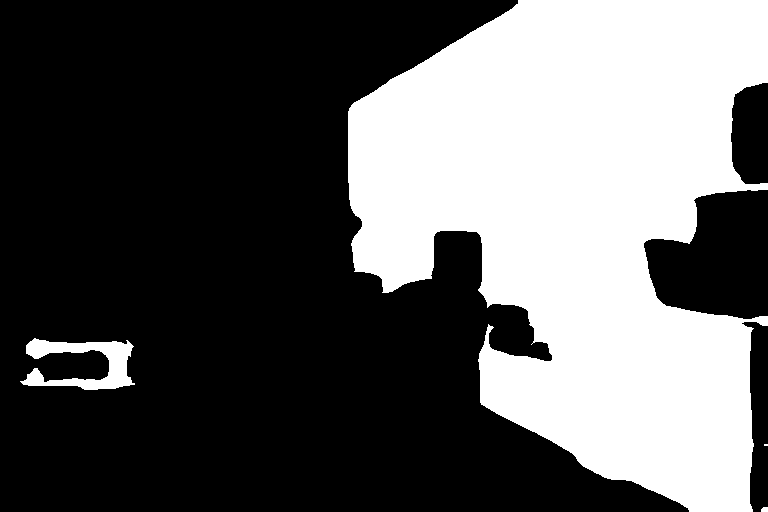

In [47]:
object_mask

In [55]:
prompt = ["A warm and cozy bedroom, furnished with blue and gray colors, a lot of plants, and a wooden armchair."] * 4
generator = [torch.Generator(device="cuda").manual_seed(i) for i in  np.random.randint(50, size=len(prompt))]
# generator = torch.manual_seed(0)

output = pipe(
    prompt, 
    image=masked_control_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * len(prompt),
    num_inference_steps=30, 
    generator=generator,
)

image_grid(output.images, rows=2, cols=2)

TypeError: an integer is required

## StableDiffusion ControlNet Inpaint Pipeline

In [11]:
from diffusers import StableDiffusionControlNetInpaintPipeline

controlnet = ControlNetModel.from_pretrained(checkpoint_name, torch_dtype=torch.float16)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()




































































































































































































































































































































































































Fetching 16 files:  31%|███▏      | 5/16 [04:35<10:45, 58.69s/it]







































































































































































































































































































































































































































Fetching 16 files: 100%|██████████| 16/16 [07:44<00:00, 29.03s/it]
`text_config_dict` is provided which will be used to init

In [10]:
import torch
import torchvision.transforms as transforms

mask = torch.Tensor(mask).repeat(3, 1, 1)
object_mask = torch.Tensor(object_mask).repeat(3, 1, 1)
control = transforms.ToTensor()(control_image)
masked_control_image = transforms.ToPILImage()(mask * control)
object_mask = transforms.ToPILImage()(object_mask)

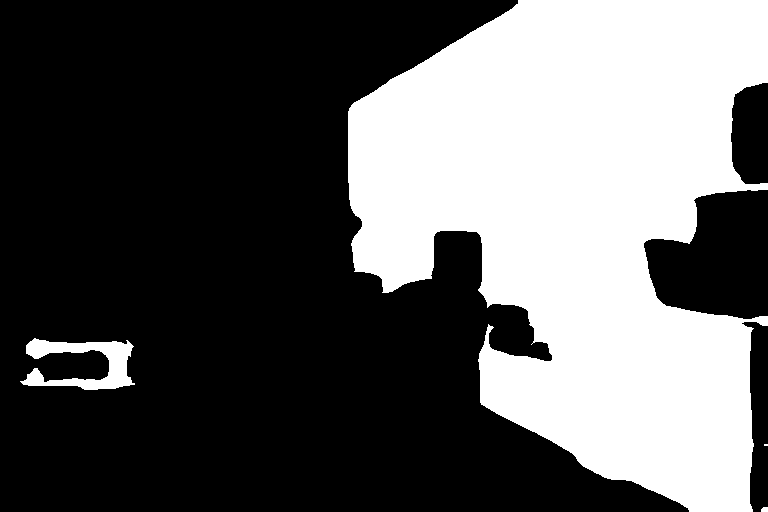

In [11]:
object_mask

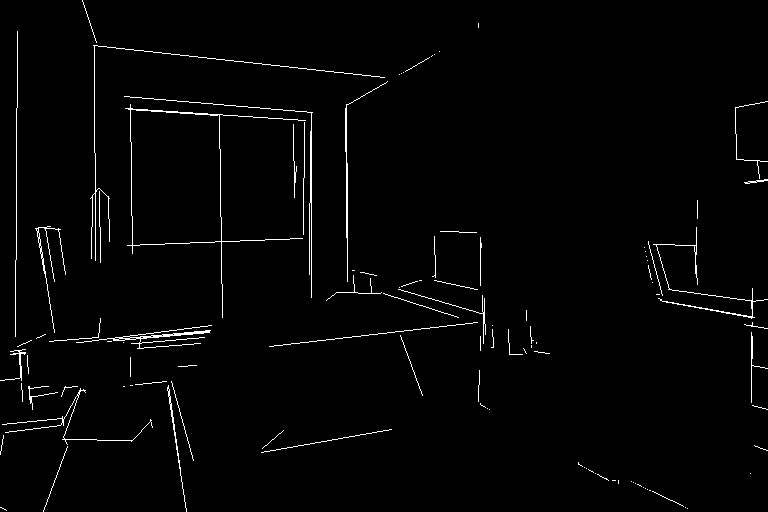

In [12]:
masked_control_image

100%|██████████| 30/30 [00:02<00:00, 11.02it/s]


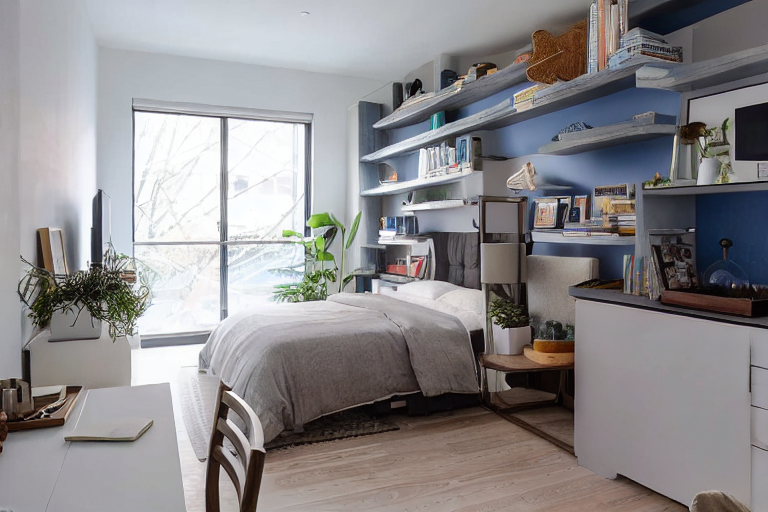

In [20]:
prompt = ["A warm and cozy bedroom, furnished with blue and gray colors, with a shelf on the wall"] * 1
generator = [torch.Generator(device="cuda").manual_seed(int(i)) for i in  np.random.randint(50, size=len(prompt))]
# generator = torch.manual_seed(0)

output = pipe(
    prompt, 
    image=image,
    control_image=masked_control_image,
    mask_image=object_mask,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * len(prompt),
    num_inference_steps=30, 
    generator=generator,
)

output.images[0]